In [39]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

import tensorflow as tf
from keras.layers import Conv1D
from keras.layers import MaxPooling1D, BatchNormalization
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
# set seed to reproduce similar results
np.random.seed(0)

In [11]:
from google.colab import drive   # 코랩 드라이브와 연동
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
Data_path= "/content/drive/MyDrive/gachon4-2/deeplearning/week4"

In [72]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv(os.path.join(Data_path,'WISDM_ar_v1.1_raw.txt'), header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["Z"] = df["Z"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()

<ipython-input-72-cbbb26fe5866>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [73]:
np.unique(df.activity.values)

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [74]:
s_df=df[df.activity=="Sitting"].iloc[:4500]
r_df=df[df.activity=="Jogging"].iloc[:4500]

print(s_df.shape)
print(r_df.shape)

(4500, 6)
(4500, 6)


In [75]:
x_df= pd.concat([s_df,r_df])
print(x_df.shape)

(9000, 6)


In [76]:
from sklearn.preprocessing import StandardScaler
x_df = x_df.drop(['user-id'], axis=1)
x_df = x_df.drop(['timestamp'], axis=1)

x_df['X'] = StandardScaler().fit_transform(x_df['X'].values.reshape(-1, 1))
x_df['Y'] = StandardScaler().fit_transform(x_df['Y'].values.reshape(-1, 1))
x_df['Z'] = StandardScaler().fit_transform(x_df['Z'].values.reshape(-1, 1))

print(x_df.shape)

(9000, 4)


In [79]:
x_df.activity[x_df.activity == "Sitting"]=0
x_df.activity[x_df.activity == "Jogging"]=1

print(np.unique(x_df.activity))

[0 1]


<ipython-input-79-29749af48ecd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df.activity[x_df.activity == "Sitting"]=0
<ipython-input-79-29749af48ecd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df.activity[x_df.activity == "Jogging"]=1


In [231]:
x_df

,activity,X,Y,Z
221333,0,0.353771,0.468699,-0.393346
221334,0,0.368867,0.451497,-0.512760
221335,0,0.521716,0.366808,-0.454584
221336,0,0.550021,0.431648,-0.417841
221337,0,0.412269,0.426355,-0.393346
...,...,...,...,...
13015,1,0.888650,0.361942,0.252714
13016,1,-0.954171,1.774960,-1.014910
13017,1,-0.332187,-1.472819,-1.633413
13018,1,1.199642,1.472171,-0.711783


In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test = train_test_split(x_df, test_size=0.2, random_state=0)
X_train = X_train[X_train.activity == 0]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape)
print(X_test.shape, " ", y_test.shape)

(3607, 3)
(1800, 3)   (1800,)


In [184]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

-1.2426446159748903 1.2692632707707026
-3.8196060955732842 3.1529798662238324


In [185]:
X_train_noise = X_train + np.random.normal(0.5, 0.1, (3))
X_test_noise = X_test + np.random.normal(0.5, 0.1, (3))

print(X_train_noise.min(), X_train_noise.max())
print(X_test_noise.min(), X_test_noise.max())

-0.5831612199215873 1.8671370691812765
-3.4173338835609255 3.877069186143978


In [188]:
from keras import regularizers
input_dim = X_train.shape[1]
encoding_dim = 14

# input_layer = Input(shape=(input_dim, ))

# encoder = Dense(encoding_dim, activation="tanh",
#                 activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

x_Input = Input(batch_shape=(None, input_dim))
x_Encoder1 = Dense(256, activation='relu')(x_Input)
x_Encoder1 = Dropout(0.3)(x_Encoder1)
x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
x_Encoder2 = Dropout(0.2)(x_Encoder2)
y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
y_Decoder1 = Dropout(0.3)(y_Decoder1)
y_Decoder2 = Dense(input_dim, activation='linear')(y_Decoder1)


autoencoder = Model(inputs=x_Input, outputs=y_Decoder2)

In [189]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_24 (Dense)            (None, 256)               1024      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0   

In [145]:
#nb_epoch = 100
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error')
# checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1
                    # ,callbacks=[checkpointer, tensorboard]
                          ).history

Epoch 1/100
102/102 [==============================] - 3s 8ms/step - loss: 0.0459 - val_loss: 0.0091
Epoch 2/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 0.0068
Epoch 3/100
102/102 [==============================] - 1s 7ms/step - loss: 0.0116 - val_loss: 0.0059
Epoch 4/100
102/102 [==============================] - 1s 7ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 5/100
102/102 [==============================] - 1s 7ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 6/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 7/100
102/102 [==============================] - 1s 7ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 8/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 9/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 10/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0054 - val_lo

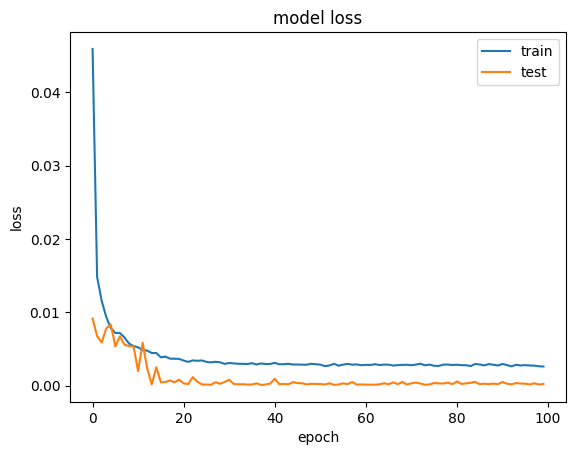

In [146]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [147]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.values})
error_df.describe()

57/57 [==============================] - 0s 2ms/step


,reconstruction_error
count,1.800000e+03
mean,3.344014e-01
std,8.356988e-01
min,4.280283e-07
25%,1.700063e-04
50%,4.984469e-03
75%,3.512694e-01
max,8.789266e+00


In [180]:
threshold = 0.01

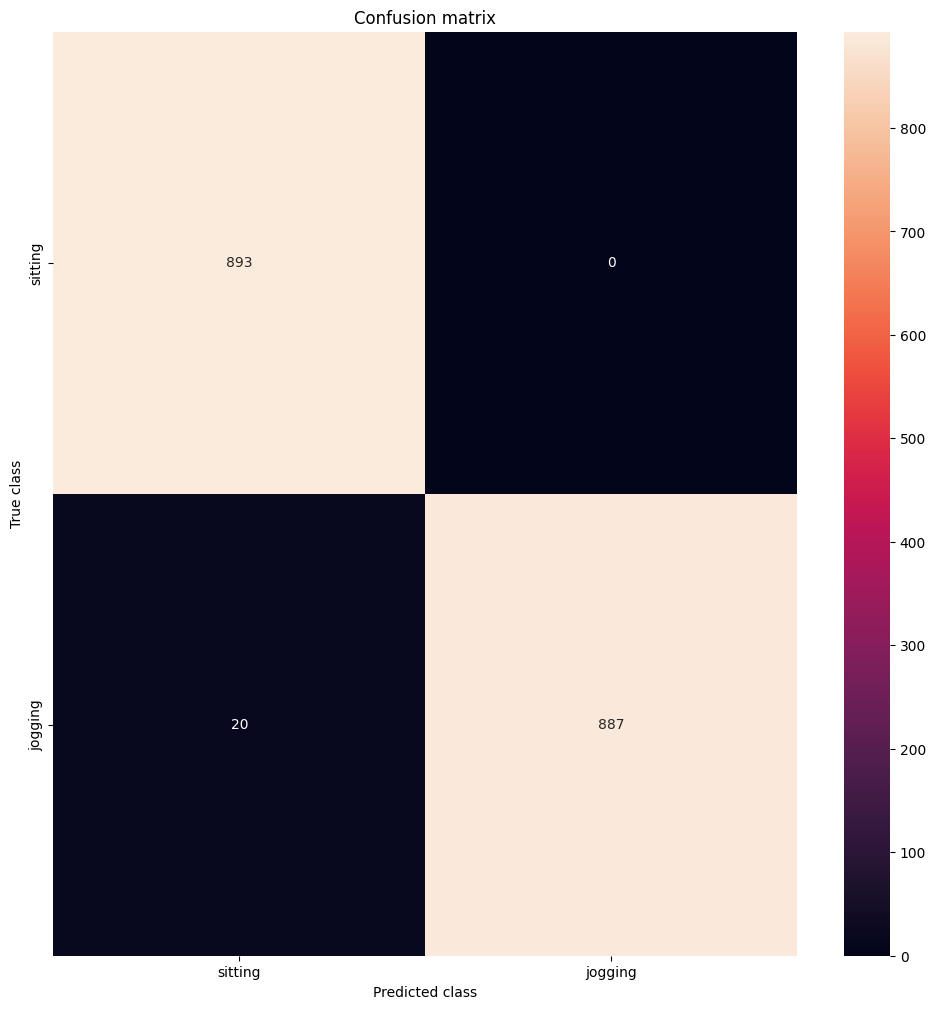

In [181]:
LABELS = ["sitting", "jogging"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(list(y_test.values), y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [182]:
from sklearn.metrics import f1_score
print(f1_score(list(y_test.values), y_pred))

0.9888517279821628


## Denosing

In [201]:
noise_factor = 0.50
X_train_noisy = X_train.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [202]:
print(X_train_noisy.min(), X_train_noisy.max())
print(X_test_noisy.min(), X_test_noisy.max())

-2.7232785316342607 2.84169616715691
-4.393192716491324 4.083083105855751


In [203]:
from keras import regularizers
input_dim = X_train.shape[1]
encoding_dim = 14

# input_layer = Input(shape=(input_dim, ))

# encoder = Dense(encoding_dim, activation="tanh",
#                 activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

x_Input = Input(batch_shape=(None, input_dim))
x_Encoder1 = Dense(256, activation='relu')(x_Input)
x_Encoder1 = Dropout(0.3)(x_Encoder1)
x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
x_Encoder2 = Dropout(0.2)(x_Encoder2)
y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
y_Decoder1 = Dropout(0.3)(y_Decoder1)
y_Decoder2 = Dense(input_dim, activation='linear')(y_Decoder1)


autoencoder = Model(inputs=x_Input, outputs=y_Decoder2)

In [204]:
#nb_epoch = 100
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error')
# checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)
history = autoencoder.fit(X_train_noisy, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1
                    # ,callbacks=[checkpointer, tensorboard]
                          ).history

Epoch 1/100
102/102 [==============================] - 3s 12ms/step - loss: 0.0864 - val_loss: 0.0427
Epoch 2/100
102/102 [==============================] - 1s 12ms/step - loss: 0.0361 - val_loss: 0.0321
Epoch 3/100
102/102 [==============================] - 2s 15ms/step - loss: 0.0261 - val_loss: 0.0370
Epoch 4/100
102/102 [==============================] - 2s 18ms/step - loss: 0.0226 - val_loss: 0.0261
Epoch 5/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0199 - val_loss: 0.0247
Epoch 6/100
102/102 [==============================] - 1s 7ms/step - loss: 0.0184 - val_loss: 0.0298
Epoch 7/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0188 - val_loss: 0.0291
Epoch 8/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0155 - val_loss: 0.0306
Epoch 9/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0165 - val_loss: 0.0259
Epoch 10/100
102/102 [==============================] - 1s 11ms/step - loss: 0.0158 -

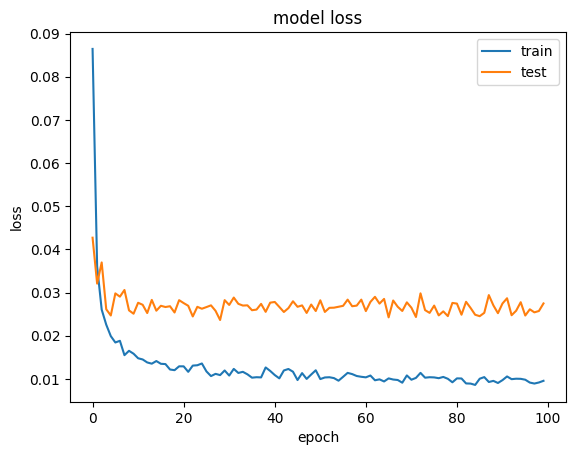

In [205]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [206]:
predictions = autoencoder.predict(X_test_noisy)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': list(y_test.values)})
error_df.describe()

57/57 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,1800.000000,1800.000000
mean,0.543383,0.503889
std,0.882198,0.500124
min,0.000092,0.000000
25%,0.001266,0.000000
50%,0.046626,1.000000
75%,0.844990,1.000000
max,8.349713,1.000000


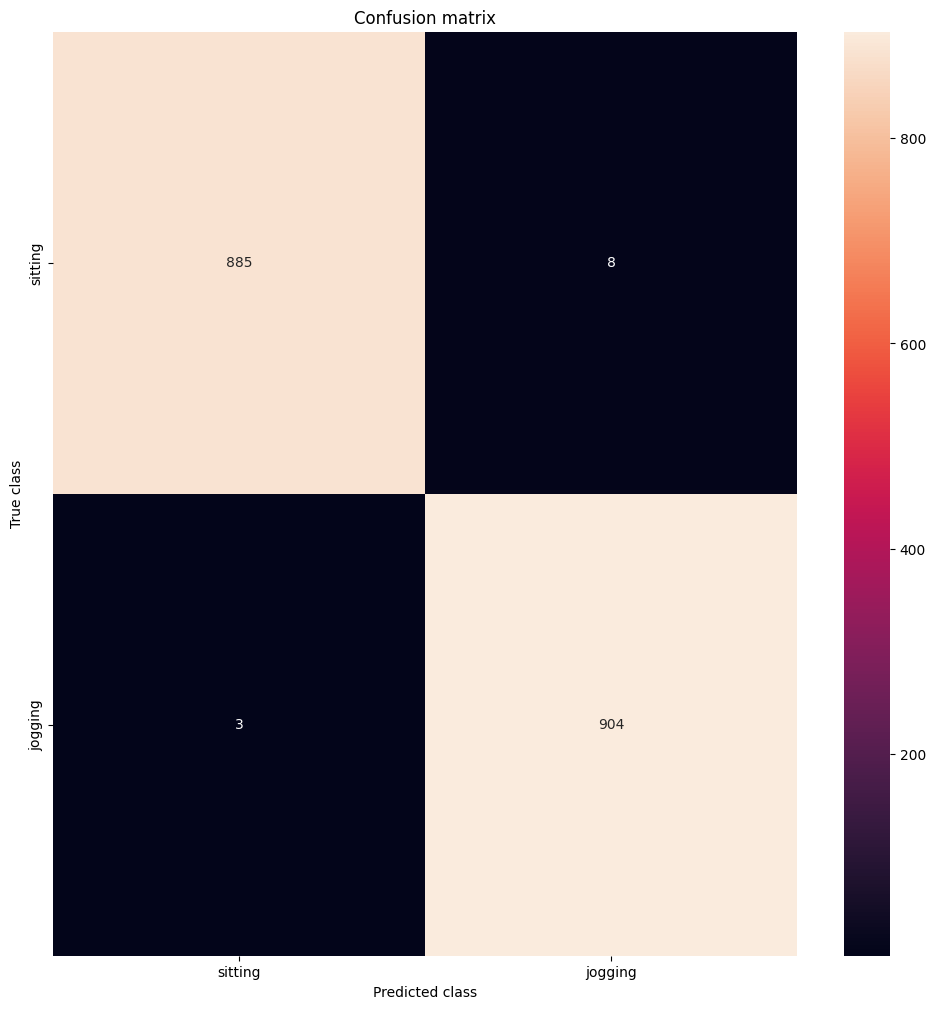

In [225]:
threshold=0.02
LABELS = ["sitting", "jogging"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(list(y_test.values), y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [226]:
from sklearn.metrics import f1_score
print(f1_score(list(y_test.values), y_pred))

0.9939527212754261


In [235]:
X_train, X_test = train_test_split(x_df, test_size=0.2, random_state=0)
X_train = X_train[X_train.activity == 0]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

In [245]:
time_step = 10
step = 1

def create_dataset(X,time_step, step, y=None):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        Xs.append(v)

        if y is not None:
          labels = y.iloc[i + time_step]
          ys.append(labels)



    if y is not None:
      return np.array(Xs),np.array(ys)
    return np.array(Xs)

In [243]:
X_train_ts = create_dataset(X_train, time_step=time_step, step=step)
X_train_ts.shape

(3597, 10, 3)

In [246]:
X_test_ts, y_test_ts = create_dataset(X_test, time_step=time_step, step=step, y=y_test)
print(X_test_ts.shape, y_test_ts.shape)

(1790, 10, 3) (1790,)


In [249]:
from keras import regularizers
from keras.layers import TimeDistributed, RepeatVector

input_dim = X_train.shape[1]
encoding_dim = 14

inputs = Input(shape=(X_train_ts.shape[1], X_train_ts.shape[2]))
L1 = LSTM(16, activation='relu', return_sequences=True,
          kernel_regularizer=regularizers.l2(0.00))(inputs)
L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
L3 = RepeatVector(X_train_ts.shape[1])(L2)
L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
output = TimeDistributed(Dense(X_train_ts.shape[2]))(L5)
autoencoder = Model(inputs=inputs, outputs=output)

autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 3)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 16)            1280      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 4)             0         
 r)                                                              
                                                                 
 lstm_6 (LSTM)               (None, 10, 4)             144       
                                                                 
 lstm_7 (LSTM)               (None, 10, 16)            1344      
                                                           

In [250]:
#nb_epoch = 100
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error')
# checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)
history = autoencoder.fit(X_train_ts, X_train_ts,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1
                    # ,callbacks=[checkpointer, tensorboard]
                          ).history

Epoch 1/100
102/102 [==============================] - 9s 22ms/step - loss: 0.6283 - val_loss: 0.5511
Epoch 2/100
102/102 [==============================] - 2s 16ms/step - loss: 0.5393 - val_loss: 0.5223
Epoch 3/100
102/102 [==============================] - 2s 16ms/step - loss: 0.5273 - val_loss: 0.5180
Epoch 4/100
102/102 [==============================] - 2s 16ms/step - loss: 0.5235 - val_loss: 0.5173
Epoch 5/100
102/102 [==============================] - 2s 16ms/step - loss: 0.5182 - val_loss: 0.5100
Epoch 6/100
102/102 [==============================] - 2s 17ms/step - loss: 0.5131 - val_loss: 0.5073
Epoch 7/100
102/102 [==============================] - 2s 24ms/step - loss: 0.5068 - val_loss: 0.4992
Epoch 8/100
102/102 [==============================] - 2s 22ms/step - loss: 0.5026 - val_loss: 0.4945
Epoch 9/100
102/102 [==============================] - 2s 16ms/step - loss: 0.5038 - val_loss: 0.5026
Epoch 10/100
102/102 [==============================] - 2s 16ms/step - loss: 0.508

In [252]:
history = autoencoder.fit(X_train_ts, X_train_ts,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1
                    # ,callbacks=[checkpointer, tensorboard]
                          ).history

Epoch 1/100
102/102 [==============================] - 7s 22ms/step - loss: 0.2824 - val_loss: 0.2825
Epoch 2/100
102/102 [==============================] - 2s 16ms/step - loss: 0.2750 - val_loss: 0.2810
Epoch 3/100
102/102 [==============================] - 2s 20ms/step - loss: 0.2752 - val_loss: 0.2857
Epoch 4/100
102/102 [==============================] - 3s 28ms/step - loss: 0.2757 - val_loss: 0.2831
Epoch 5/100
102/102 [==============================] - 2s 23ms/step - loss: 0.2744 - val_loss: 0.2803
Epoch 6/100
102/102 [==============================] - 2s 16ms/step - loss: 0.2766 - val_loss: 0.2836
Epoch 7/100
102/102 [==============================] - 2s 16ms/step - loss: 0.2739 - val_loss: 0.2844
Epoch 8/100
102/102 [==============================] - 2s 16ms/step - loss: 0.2746 - val_loss: 0.2816
Epoch 9/100
102/102 [==============================] - 2s 17ms/step - loss: 0.2747 - val_loss: 0.2796
Epoch 10/100
102/102 [==============================] - 2s 22ms/step - loss: 0.273

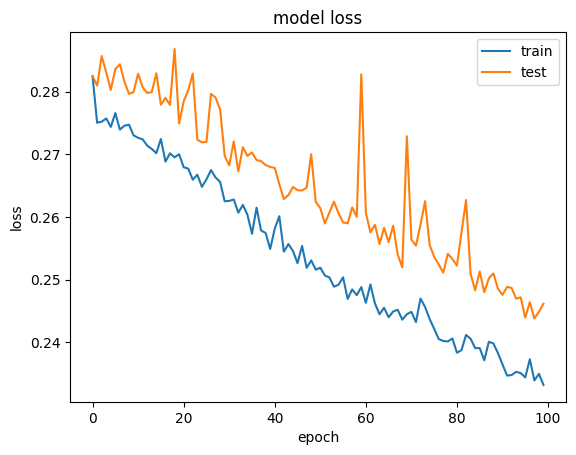

In [253]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test_ts)
predictions = predictions.reshape(predictions.shape[0], X_test.shape[2])
X_test_ts2 = X_test_ts.reshape(X_test.shape[0], X_test.shape[2])

mse = np.mean(np.power(X_test_ts2 - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': list(y_test.values)})
error_df.describe()

In [260]:
X_test.shape

(1800, 3)

In [261]:
predictions.shape

(1790, 10, 3)

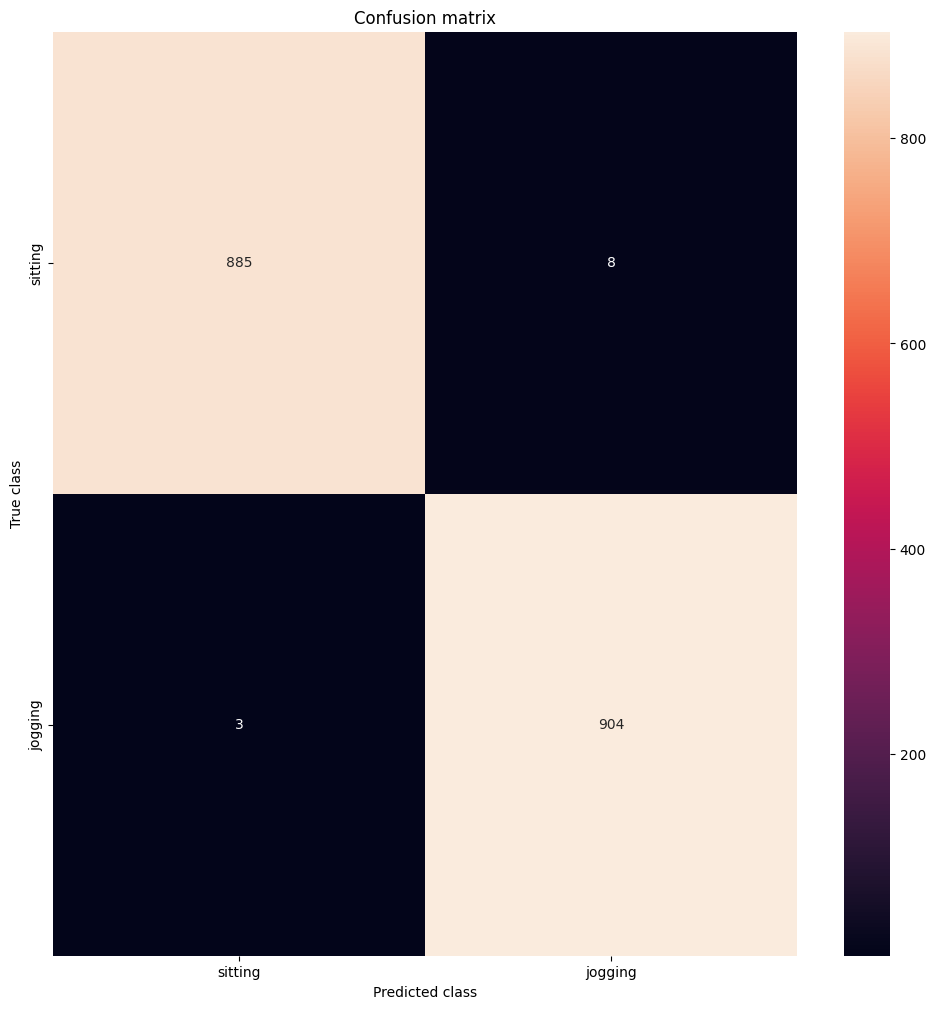

In [ ]:
threshold=0.02
LABELS = ["sitting", "jogging"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(list(y_test.values), y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(list(y_test.values), y_pred))

0.9939527212754261
